## Selecting band comparison segments


In [1]:
import numpy as np
from PIL import Image
from glob import glob
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mahotas
import os
from tqdm import tqdm

In [8]:
truth_paths = sorted(glob('truth_masks_sentinel/*'))
slic_paths = sorted(glob('slics_manysegs/*.npy'))
assert len(truth_paths) == len(slic_paths)

In [9]:
# 0 - Fundo
# 1 - Desmatamento recente
# 2 - Floresta
# 3 - Ñ analisado

def is_mixed(segment):
    # flattening segment
    segment = segment.flatten()

    NFP = np.count_nonzero(segment == 2)
    NP = np.count_nonzero(segment) # desconsiderando o fundo (np.zeros)
    NNP = NP - NFP

    if NFP != 0 and NNP != 0:
        return True
    

    return False
    
def get_hor(segment):
    # flattening segment
    segment = segment.flatten()

    NFP = np.where(segment == 0, 1, 0).sum()
    NP = segment.size
    NNP = NP - NFP

    HoR = max([NFP, NNP]) / NP

    return HoR

def get_major_class(segment):
    if np.argmax(np.bincount(segment.flatten())) == 0:
        return "forest"
    elif np.argmax(np.bincount(segment.flatten())) == 1:
        return "non forest"
    else:
        return np.argmax(np.bincount(segment.flatten()))
    
def get_region(path):
    return f"{path.split('/')[-1].split('.')[0].split('_')[-1].split('-')[0]}"

In [10]:
segments_truth_df = []
global_segment_array = []
global_perfect_segments = []
for idx in range(len(slic_paths)):
    total_segs = 0
    good_segs = 0
    bad_by_hor = 0
    bad_by_size = 0
    n_perfect_segs = 0
    truth = np.load(truth_paths[idx])
    truth = np.where(truth != 2, 1, 0)
    slic = np.load(slic_paths[idx])
    region = get_region(slic_paths[idx])

    props = regionprops(slic)
    segments_truth = []
    bad_segment_ids = []
    perfect_segs_truth = []

    assert slic.shape[:2] == truth.shape[:2]
    for i, prop in enumerate(props):
        total_segs += 1
        minr, minc, maxr, maxc = prop.bbox
        coords = np.array(prop.coords)
        segment_truth = truth[minr:maxr, minc:maxc]
        hor = get_hor(segment_truth)
        classification = get_major_class(np.uint8(segment_truth))
        if (segment_truth.shape[0] * segment_truth.shape[1] > 630) and (hor > 0.7) and (classification in ["forest", "non forest"]):
            segments_truth.append(np.uint8(segment_truth))
            segments_truth_df.append({"Segment_label": prop.label, "HoR": hor, "Class": classification, "Region": region})
            good_segs += 1
        if (hor<= 0.7):
            bad_by_hor += 1
            bad_segment_ids.append(prop.label)
        if (segment_truth.shape[0] * segment_truth.shape[1] <= 630):
            bad_by_size += 1
            bad_segment_ids.append(prop.label)
        if (hor== 1):
            perfect_segs_truth.append(segment_truth)
            n_perfect_segs += 1
    global_segment_array.append(segments_truth)
    global_perfect_segments.append(perfect_segs_truth)

    print(f'{region}: total_segs = {total_segs :4d} | good_segs = {good_segs :4d} | bad_segs = {(total_segs - good_segs) :4d} | bad_segs because of HoR = {bad_by_hor :4d} | bad_segs because of size = {bad_by_size :4d} | perfect_segs = {n_perfect_segs :4d}')

    

x01: total_segs = 44703 | good_segs = 5446 | bad_segs = 39257 | bad_segs because of HoR = 1541 | bad_segs because of size = 38941 | perfect_segs = 39460
x02: total_segs = 66428 | good_segs = 2055 | bad_segs = 64373 | bad_segs because of HoR = 3079 | bad_segs because of size = 64089 | perfect_segs = 55490
x03: total_segs = 44459 | good_segs = 4319 | bad_segs = 40140 | bad_segs because of HoR = 2982 | bad_segs because of size = 39581 | perfect_segs = 33690
x04: total_segs = 37593 | good_segs =  645 | bad_segs = 36948 | bad_segs because of HoR = 3302 | bad_segs because of size = 36812 | perfect_segs = 26369
x06: total_segs = 47211 | good_segs = 1295 | bad_segs = 45916 | bad_segs because of HoR = 3390 | bad_segs because of size = 45760 | perfect_segs = 35699
x07: total_segs = 91737 | good_segs = 1085 | bad_segs = 90652 | bad_segs because of HoR = 5868 | bad_segs because of size = 90478 | perfect_segs = 72137
x08: total_segs = 42635 | good_segs = 1241 | bad_segs = 41394 | bad_segs because o

In [11]:
segments_truth_df = pd.DataFrame.from_records(segments_truth_df)

In [13]:
segments_truth_df.head()

,Segment_label,HoR,Class,Region
0,1,0.94461,forest,x01
1,4,1.00000,forest,x01
2,22,1.00000,forest,x01
3,35,1.00000,forest,x01
4,44,1.00000,forest,x01


In [14]:
regions = segments_truth_df['Region'].unique()
for region in regions:
    forest_count = segments_truth_df[(segments_truth_df['Region'] == region) & (segments_truth_df['Class'] == 'forest')].shape[0]
    non_forest_count = segments_truth_df[(segments_truth_df['Region'] == region) & (segments_truth_df['Class'] == 'non forest')].shape[0]
    print(f'{region}: forest = {forest_count} | non forest = {non_forest_count}')

x01: forest = 4321 | non forest = 1125
x02: forest = 941 | non forest = 1114
x03: forest = 2568 | non forest = 1751
x04: forest = 104 | non forest = 541
x06: forest = 339 | non forest = 956
x07: forest = 548 | non forest = 537
x08: forest = 797 | non forest = 444
x09: forest = 4570 | non forest = 532
x10: forest = 216 | non forest = 478


In [8]:
# segments_image_df.to_csv('segments_pca.csv', index=False)

Text(0.5, 1.0, 'Boxplot | all regions')

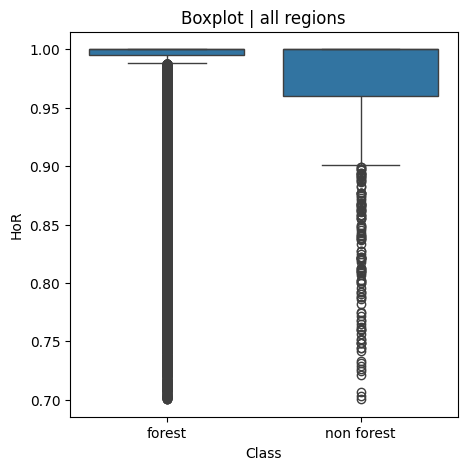

In [9]:
fig = plt.figure(figsize=(5, 5))
data = segments_truth_df
data = data.reset_index(drop=True)
ax = sns.boxplot(data, x='Class', y='HoR')
ax.set_title(f'Boxplot | all regions')


## Calculating Haralick features for every band and saving segment files


In [13]:
info = []
regions = segments_truth_df['Region'].unique()
val_region = ['x08']
test_regions = ['x03', 'x04']

# clearing destination folders
os.system(f'rm -r data/classification_dataset/train/forest/*')
os.system(f'rm -r data/classification_dataset/train/non_forest/*')
os.system(f'rm -r data/classification_dataset/val/forest/*')
os.system(f'rm -r data/classification_dataset/val/non_forest/*')
os.system(f'rm -r data/classification_dataset/test/forest/*')
os.system(f'rm -r data/classification_dataset/test/non_forest/*')

for region in regions:
    region_segments = segments_truth_df[segments_truth_df['Region'] == region]
    counts = region_segments['Class'].value_counts()
    
    # selecting segments
    selected_segments = region_segments.sort_values(by='HoR', ascending=False)

    ## exporting segments

    # getting labels
    forest_labels = (selected_segments[selected_segments['Class'] == 'forest'])['Segment_label'].values
    non_forest_labels = selected_segments[selected_segments['Class'] == 'non forest']['Segment_label'].values

    # loading scenes
    image = np.load(f'scenes_multiIndex/{region}.npy')
    slic = np.load(f'slics/slic_{region}-pca.npy')
    props = regionprops(slic)

    
    ## saving segments

    saved_forest = 0
    saved_nonforest = 0
    for prop in tqdm(props, desc=f'{region}'):
        minr, minc, maxr, maxc = prop.bbox
        image_segment = np.zeros((maxr - minr, maxc - minc, image.shape[-1]))
        coords = np.array(prop.coords)
        for pixel in coords:
            image_segment[pixel[0] - minr, pixel[1] - minc] = image[pixel[0], pixel[1]]
        
        img = np.uint8(image_segment)
        har_bands = []

        for band in range(img.shape[-1]):
            har_forest = mahotas.features.haralick(img[:, :, band])
            har_bands.append(har_forest)
    
        img = np.stack(har_bands)

        if prop.label in forest_labels:
        #     if region in test_regions:
        #         np.save(f'data/classification_dataset/test/forest/forest_{region}_{prop.label}.npy', img)
        #     elif region in val_region:
        #         np.save(f'data/classification_dataset/val/forest/forest_{region}_{prop.label}.npy', img)
        #     else:
        #         np.save(f'data/classification_dataset/train/forest/forest_{region}_{prop.label}.npy', img)
            saved_forest += 1
        elif prop.label in non_forest_labels:
        #     if region in test_regions:
        #         np.save(f'data/classification_dataset/test/non_forest/nonforest_{region}_{prop.label}.npy', img)
        #     elif region in val_region:
        #         np.save(f'data/classification_dataset/val/non_forest/nonforest_{region}_{prop.label}.npy', img)
        #     else:
        #         np.save(f'data/classification_dataset/train/non_forest/nonforest_{region}_{prop.label}.npy', img)
            saved_nonforest += 1

       
    info.append(dict(region=region, forest=saved_forest, nonforest=saved_nonforest, total=(saved_forest + saved_nonforest)))

In [ ]:
log = pd.DataFrame.from_records(info)
log

,region,forest,nonforest,total
0,x01,2919,224,3143
1,x02,2784,359,3143
2,x03,2282,55,2337
3,x04,623,15,638
4,x06,1415,27,1442
5,x07,6040,42,6082
6,x08,1608,73,1681
7,x09,2971,48,3019
8,x10,1945,108,2053


In [ ]:
log.sum()

region       x01x02x03x04x06x07x08x09x10
forest                             22587
nonforest                            951
total                              23538
dtype: object